In [1]:
import os
import cv2
import math
import numpy as np
from scipy import optimize

import dlib
from dlib import rectangle

In [2]:
def LineSearchFun(alpha, x, d, fun, args):
    r = fun(x + alpha * d, *args)
    return np.sum(r**2)

In [3]:
def GaussNewton(x0, fun, funJack, args, maxIter=10, eps=10e-7, verbose=1):
    x = np.array(x0, dtype=np.float64)

    oldCost = -1
    for i in range(maxIter):
        r = fun(x, *args)
        cost = np.sum(r**2)

        if (cost < eps or abs(cost - oldCost) < eps):
            break
        oldCost = cost

        J = funJack(x, *args)
        grad = np.dot(J.T, r)
        H = np.dot(J.T, J)
        direction = np.linalg.solve(H, grad)

        lineSearchRes = optimize.minimize_scalar(LineSearchFun, args=(x, direction, fun, args))
        alpha = lineSearchRes["x"]

        x = x + alpha * direction
    return x

In [4]:
def SteepestDescent(x0, fun, funJack, args, maxIter=10, eps=10e-7, verbose=1):
    x = np.array(x0, dtype=np.float64)

    oldCost = -1
    for i in range(maxIter):
        r = fun(x, *args)
        cost = np.sum(r**2)

        if (cost < eps or abs(cost - oldCost) < eps):
            break
        oldCost = cost

        J = funJack(x, *args)
        grad = 2 * np.dot(J.T, r)
        direction = grad
        lineSearchRes = optimize.minimize_scalar(LineSearchFun, args=(x, direction, fun, args))
        alpha = lineSearchRes["x"]
        x = x + alpha * direction
    return x

In [5]:
def getNormal(triangle):
    a = triangle[:, 0]
    b = triangle[:, 1]
    c = triangle[:, 2]

    axisX = b - a
    axisX = axisX / np.linalg.norm(axisX)
    axisY = c - a
    axisY = axisY / np.linalg.norm(axisY)
    axisZ = np.cross(axisX, axisY)
    axisZ = axisZ / np.linalg.norm(axisZ)

    return axisZ

In [6]:
def flipWinding(triangle):
    return [triangle[1], triangle[0], triangle[2]]

In [7]:
def fixMeshWinding(mesh, vertices):
    for i in range(mesh.shape[0]):
        triangle = mesh[i]
        normal = getNormal(vertices[:, triangle])
        if normal[2] > 0:
            mesh[i] = flipWinding(triangle)
    return mesh

In [8]:
def getShape3D(mean3DShape, blendshapes, params):
    s = params[0]
    r = params[1:4]
    t = params[4:6]
    w = params[6:]

    R = cv2.Rodrigues(r)[0]
    shape3D = mean3DShape + np.sum(w[:, np.newaxis, np.newaxis] * blendshapes, axis=0)
    shape3D = s * np.dot(R, shape3D)
    shape3D[:2, :] = shape3D[:2, :] + t[:, np.newaxis]

    return shape3D

In [9]:
def getMask(renderedImg):
    mask = np.zeros(renderedImg.shape[:2], dtype=np.uint8)

In [10]:
def load3DFaceModel(filename):
    faceModelFile = np.load(filename)
    mean3DShape = faceModelFile["mean3DShape"]
    mesh = faceModelFile["mesh"]
    idxs3D = faceModelFile["idxs3D"]
    idxs2D = faceModelFile["idxs2D"]
    blendshapes = faceModelFile["blendshapes"]
    mesh = fixMeshWinding(mesh, mean3DShape)

    return mean3DShape, blendshapes, mesh, idxs3D, idxs2D

In [11]:
def getFaceKeypoints(img, detector, predictor, maxImgSizeForDetection=640):
    imgScale = 1
    scaledImg = img
    if max(img.shape) > maxImgSizeForDetection:
        imgScale = maxImgSizeForDetection / float(max(img.shape))
        scaledImg = cv2.resize(img, (int(img.shape[1] * imgScale), int(img.shape[0] * imgScale)))
    
    dets = detector(scaledImg, 1)
    if len(dets) == 0:
        return None
    
    shapes2D = []
    for det in dets:
        faceRectangle = rectangle(int(det.left() / imgScale), int(det.top() / imgScale), int(det.right() / imgScale), int(det.bottom() / imgScale))
        dlibShape = predictor(img, faceRectangle)
        shape2D = np.array([[p.x, p.y] for p in dlibShape.parts()])
        shape2D = shape2D.T
        shapes2D.append(shape2D)
    return shapes2D

In [12]:
def getFaceTextureCoords(img, mean3DShape, blendshapes, idxs2D, idxs3D, detector, predictor):
    projectionModel = OrthographicProjectionBlendshapes(blendshapes.shape[0])
    keypoints = getFaceKeypoints(img, detector, predictor)[0]
    modelParams = projectionModel.getInitialParameters(mean3DShape[:, idxs3D], keypoints[:, idxs2D])
    modelParams = GaussNewton(modelParams, projectionModel.residual, projectionModel.jacobian, ([mean3DShape[:, idxs3D], blendshapes[:, :, idxs3D]], keypoints[:, idxs2D]), verbose=0)
    textureCoords = projectionModel.fun([mean3DShape, blendshapes], modelParams)
    return textureCoords

In [13]:
class OrthographicProjectionBlendshapes:
    nParams = 6

    def __init__(self, nBlendshapes):
        self.nBlendshapes = nBlendshapes
        self.nParams += nBlendshapes
    
    def residual(self, params, x, y):
        r = y - self.fun(x, params)
        r = r.flatten()
        return r

    def fun(self, x, params):
        s = params[0]
        r = params[1:4]
        t = params[4:6]
        w = params[6:]
        
        mean3DShape = x[0]
        blendshapes = x[1]
        
        R = cv2.Rodrigues(r)[0]
        P = R[:2]
        shape3D = mean3DShape + np.sum(w[:, np.newaxis, np.newaxis] * blendshapes, axis=0)

        projected = s * np.dot(P, shape3D) + t[:, np.newaxis]
        return projected

    def jacobian(self, params, x, y):
        s = params[0]
        r = params[1:4]
        t = params[4:6]
        w = params[6:]

        mean3DShape = x[0]
        blendshapes = x[1]

        R = cv2.Rodrigues(r)[0]
        P = R[:2]
        shape3D = mean3DShape + np.sum(w[:, np.newaxis, np.newaxis] * blendshapes, axis=0)

        nPoints = mean3DShape.shape[1]

        jacobian = np.zeros((nPoints * 2, self.nParams))
        jacobian[:, 0] = np.dot(P, shape3D).flatten()

        stepSize = 10e-4
        step = np.zeros(self.nParams)
        step[1] = stepSize;
        jacobian[:, 1] = ((self.fun(x, params + step) - self.fun(x, params)) / stepSize).flatten()
        step = np.zeros(self.nParams)
        step[2] = stepSize;
        jacobian[:, 2] = ((self.fun(x, params + step) - self.fun(x, params)) / stepSize).flatten()
        step = np.zeros(self.nParams)
        step[3] = stepSize;
        jacobian[:, 3] = ((self.fun(x, params + step) - self.fun(x, params)) / stepSize).flatten()

        jacobian[:nPoints, 4] = 1
        jacobian[nPoints:, 5] = 1

        startIdx = self.nParams - self.nBlendshapes
        for i in range(self.nBlendshapes):
            jacobian[:, i + startIdx] = s * np.dot(P, blendshapes[i]).flatten()
        return jacobian

    def getExampleParameters(self):
        params = np.zeros(self.nParams)
        params[0] = 1
        return params
    
    def getInitialParameters(self, x, y):
        mean3DShape = x.T
        shape2D = y.T
        shape3DCentered = mean3DShape - np.mean(mean3DShape, axis=0)
        shape2DCentered = shape2D - np.mean(shape2D, axis=0)
        
        scale = np.linalg.norm(shape2DCentered) / np.linalg.norm(shape3DCentered[:, :2]) 
        t = np.mean(shape2D, axis=0) - np.mean(mean3DShape[:, :2], axis=0)

        params = np.zeros(self.nParams)
        params[0] = scale
        params[4] = t[0]
        params[5] = t[1]

        return params

In [14]:
def drawPoints(img, points, color=(0, 255, 0)):
    for point in points:
        cv2.circle(img, (int(point[0]), int(point[1])), 2, color)

In [15]:
def drawCross(img, params, center=(470, 150), scale=30.0):
    R = cv2.Rodrigues(params[1:4])[0] # rotation matrix
    dst, jacobian = cv2.Rodrigues(params[1:4])
    
    points = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
    points = np.dot(points, R.T)
    points2D = points[:, :2]

    points2D = (points2D * scale + center).astype(np.int32)
    cv2.line(img, (center[0], center[1]), (points2D[0, 0], points2D[0, 1]), (255, 0, 0), 3)
    cv2.line(img, (center[0], center[1]), (points2D[1, 0], points2D[1, 1]), (0, 255, 0), 3)
    cv2.line(img, (center[0], center[1]), (points2D[2, 0], points2D[2, 1]), (0, 0, 255), 3)

    return points2D

In [16]:
def drawMesh(img, shape, mesh, color=(255, 0, 0)):
    for triangle in mesh:
        point1 = shape[triangle[0]].astype(np.int32)
        point2 = shape[triangle[1]].astype(np.int32)
        point3 = shape[triangle[2]].astype(np.int32)

        cv2.line(img, (point1[0], point1[1]), (point2[0], point2[1]), (255, 0, 0), 1)
        cv2.line(img, (point2[0], point2[1]), (point3[0], point3[1]), (255, 0, 0), 1)
        cv2.line(img, (point3[0], point3[1]), (point1[0], point1[1]), (255, 0, 0), 1)

In [17]:
def drawProjectedShape(img, x, projection, mesh, params, lockedTranslation=False):
    localParams = np.copy(params)

    if lockedTranslation:
        localParams[4] = 100
        localParams[5] = 200

    projectedShape = projection.fun(x, localParams)
    return projectedShape.T

In [18]:
def pad(img, r_x, r_y, max_size):
    crop_r_x = 0 if r_x < 0 else r_x
    crop_r_y = 0 if r_y < 0 else r_y
    crop = img[crop_r_y:r_y + max_size, crop_r_x:r_x + max_size]

    # pad top
    if r_y < 0:
        padding = [(-r_y, 0), (0, 0), (0, 0)]
        crop = np.pad(crop, padding, 'edge')
    # pad bottom
    elif r_y + max_size > img.shape[0]:
        padding = [(0, max_size - (img.shape[0] - r_y)), (0, 0), (0, 0)]
        crop = np.pad(crop, padding, 'edge')
    # pad left
    if r_x < 0:
        padding = [(0, 0), (-r_x, 0), (0, 0)]
        crop = np.pad(crop, padding, 'edge')
    # pad right
    elif r_x + max_size > img.shape[1]:
        padding = [(0, 0), (0, max_size - (img.shape[1] - r_x)), (0, 0)]
        crop = np.pad(crop, padding, 'edge')
    return crop

In [19]:
def normalize(img):
    dst = np.zeros(shape=img.shape)
    img = cv2.normalize(img, dst, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return img

In [20]:
def mean_pred(y_true, y_pred):
    return K.sqrt(K.sum(K.square((y_pred - y_true)), axis=1))

In [21]:
def crop_eyes_candide(img, points):
    l_eye_w = points[40] - points[46]
    l_eye_h = points[45] - min(points[43], points[39])
    l_size =  l_eye_w * 1.2

    r_eye_w = points[112] - points[106]
    r_eye_h = points[111] - min(points[109], points[105])
    r_size = r_eye_w * 1.2

    max_size = max(l_size, r_size)

    l_x = int(points[46] - (max_size - l_eye_w) * 0.5)
    l_y = int(min(points[43], points[39]) - (max_size - l_eye_h) * 0.5)

    r_x = int(points[106] - (max_size - r_eye_w) * 0.5)
    r_y = int(min(points[109], points[105]) - (max_size - r_eye_h) * 0.5)

    max_size = int(max_size)

    elo = pad(img, l_x, l_y, max_size)
    ero = pad(img, r_x, r_y, max_size)

    return (elo, ero)

# candide feature

In [22]:
candide_path = './candide.npz'
face_land_marks_path = './shape_predictor_68_face_landmarks.dat'

In [23]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(face_land_marks_path)
mean3DShape, blendshapes, mesh, idxs3D, idxs2D = load3DFaceModel(candide_path)
projectionModel = OrthographicProjectionBlendshapes(blendshapes.shape[0])

In [24]:
def get_features(img):
    face_feature = None
    shapes2D = getFaceKeypoints(img, detector, predictor, maxImgSizeForDetection=320)

    if shapes2D is None:
        return None, img, None, None
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    for shape2D in shapes2D:
        modelParams = projectionModel.getInitialParameters(mean3DShape[:, idxs3D], shape2D[:, idxs2D])
        modelParams = GaussNewton(modelParams, projectionModel.residual, projectionModel.jacobian, ([mean3DShape[:, idxs3D], blendshapes[:, :, idxs3D]], shape2D[:, idxs2D]), verbose=0)

        # visualize
        drawPoints(img, shape2D.T)
        drawCross(img, modelParams, center=(img.shape[1] - 50, 50))
        projectedShape = drawProjectedShape(img, [mean3DShape, blendshapes], projectionModel, mesh, modelParams, lockedTranslation=False)
        drawMesh(img, projectedShape, mesh)

        # predict
        elo, ero = crop_eyes_candide(img_gray, projectedShape.flatten())
        face_feature = modelParams.flatten()
        
    return face_feature, img, elo, ero

# samples

In [25]:
from skimage import io
import matplotlib.pyplot as plt

%matplotlib inline

In [26]:
imgs = [io.imread("./imgs/s{:03d}.jpg".format(i)) for i in range(1,5)]

In [27]:
def show_sample(img, idx):
    fig=plt.figure(figsize=(64, 64))
    n, c = 8, 1
    face_feature, post_img, elo, ero = get_features(img)
    if face_feature is not None:
        fig.add_subplot(n, c, idx)
        plt.imshow(post_img)
    else:
        plt.imshow(img)
        print("failed to detect [{}]".format(idx))

failed to detect [2]
failed to detect [3]


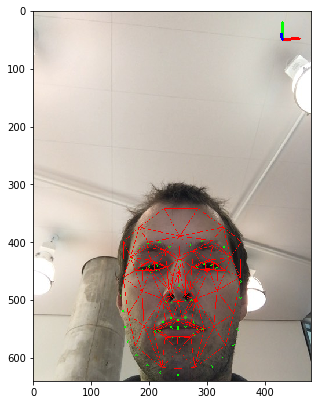

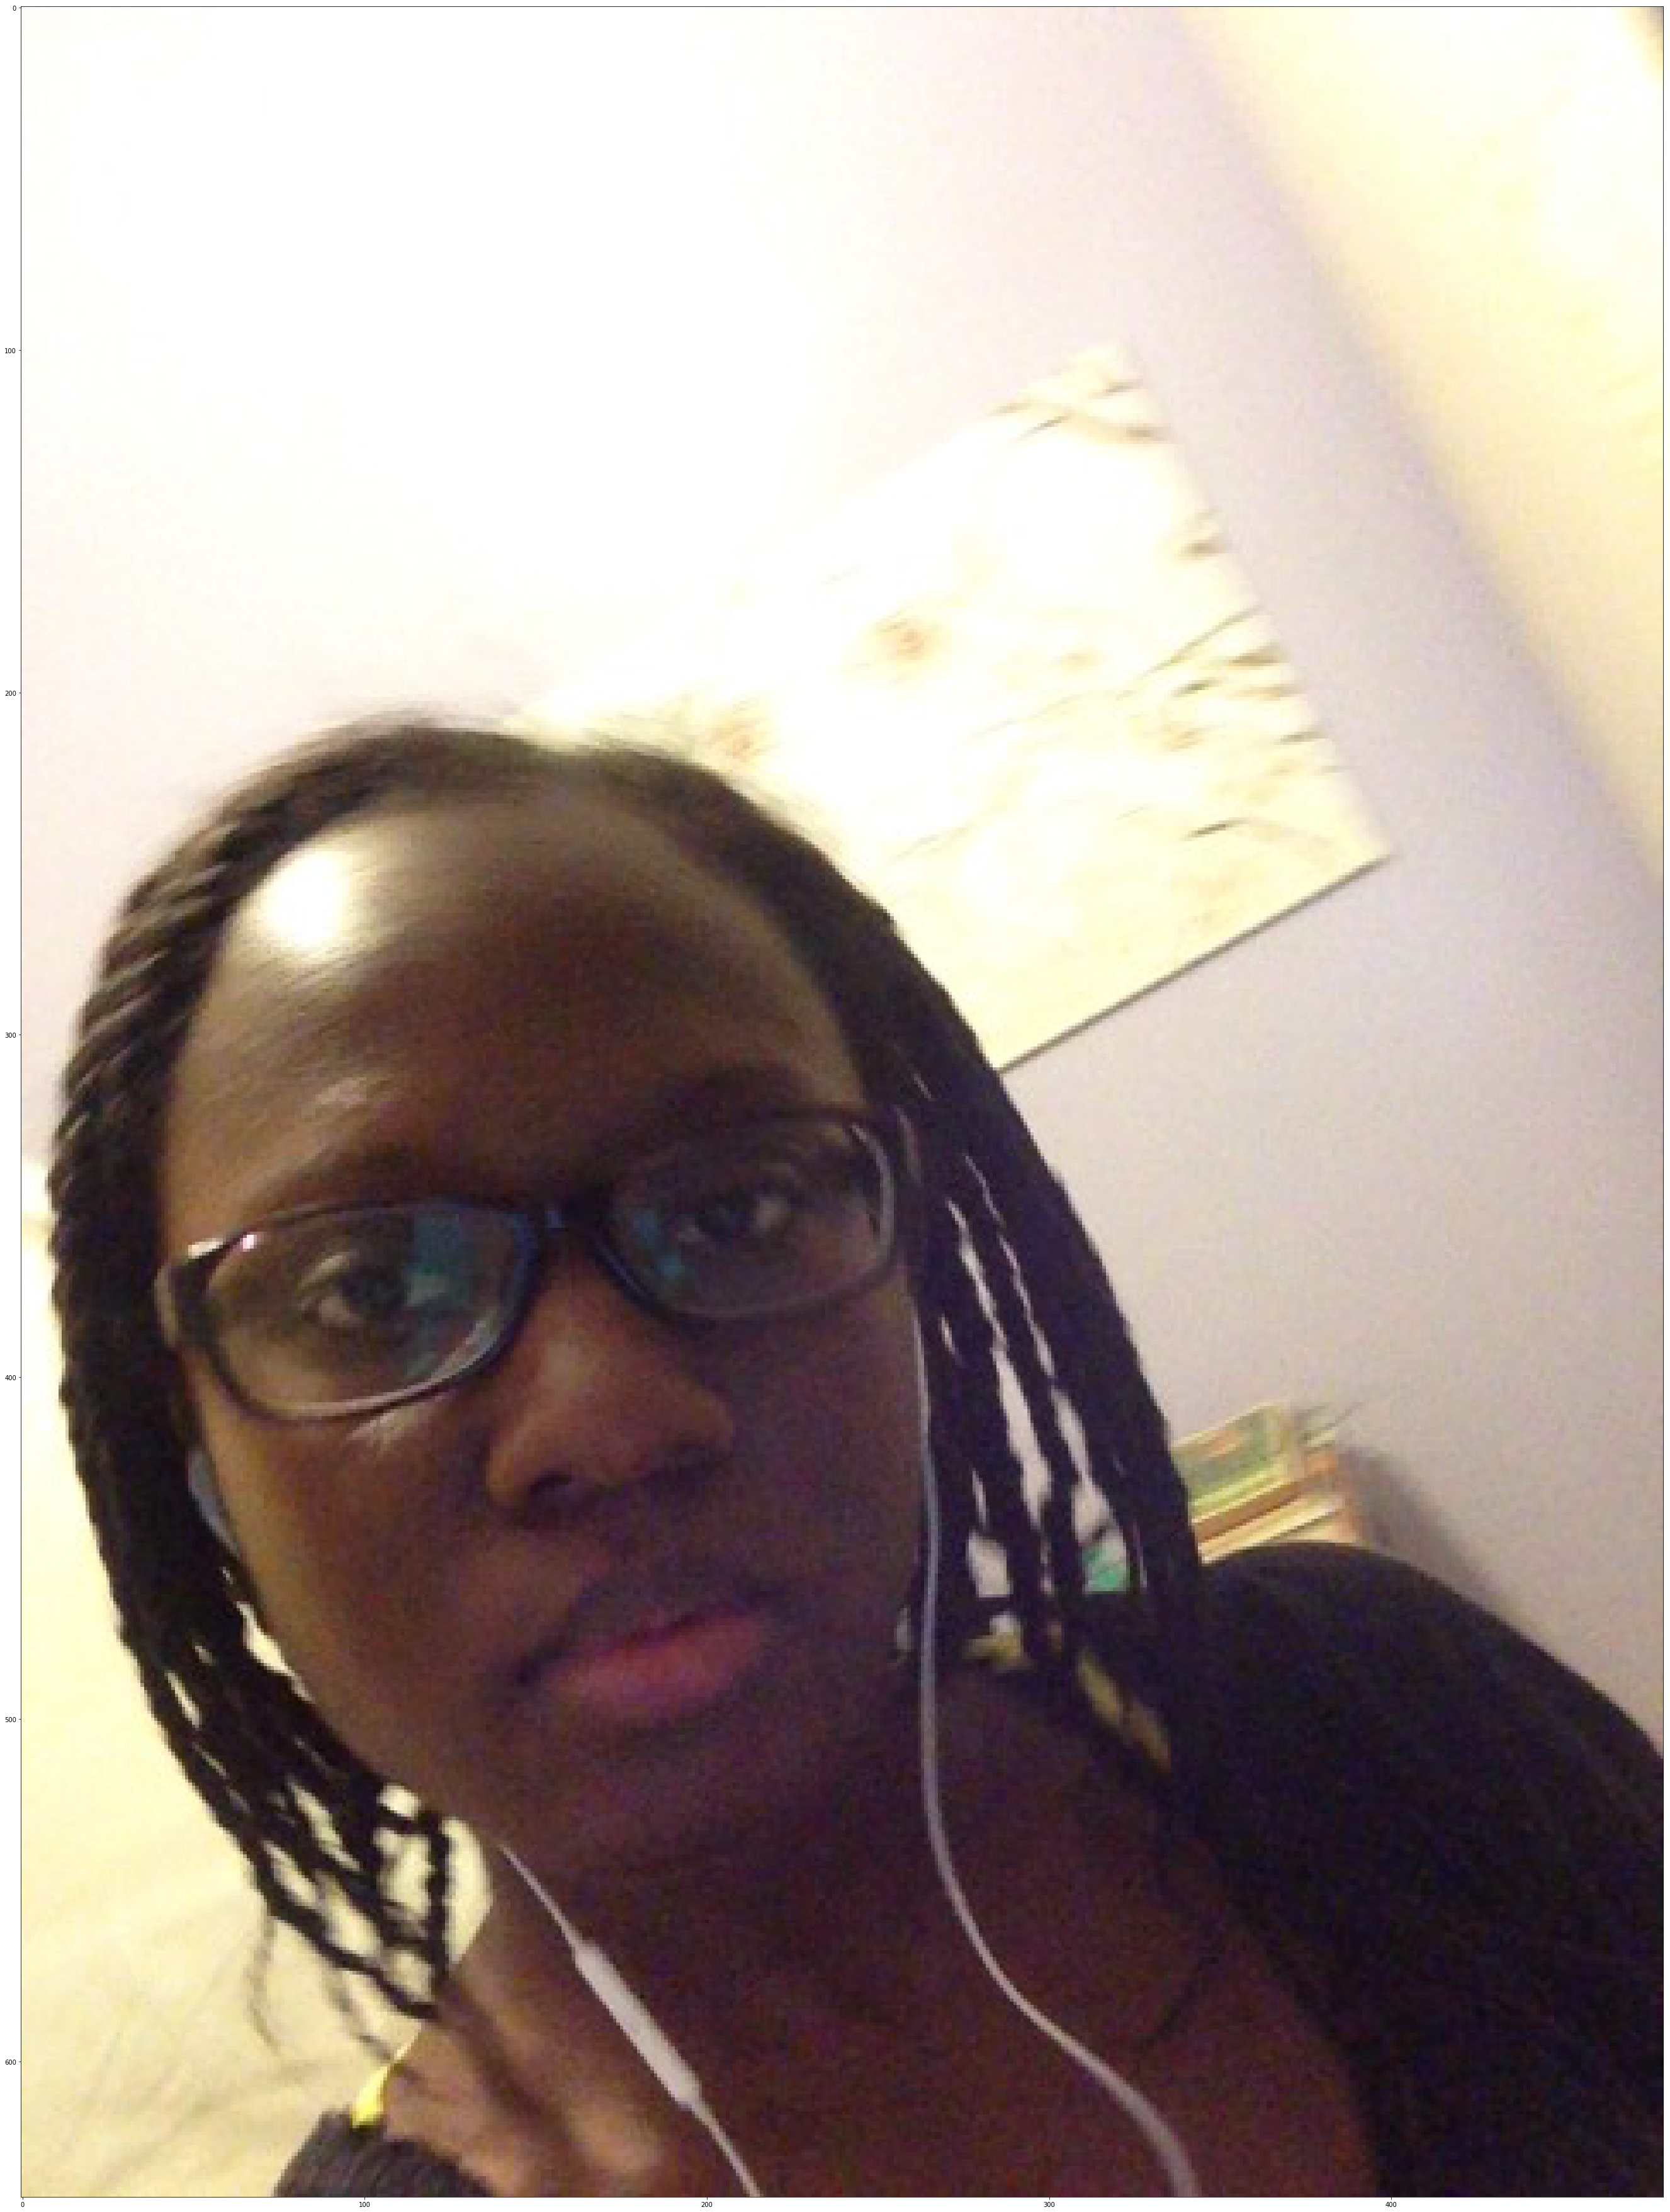

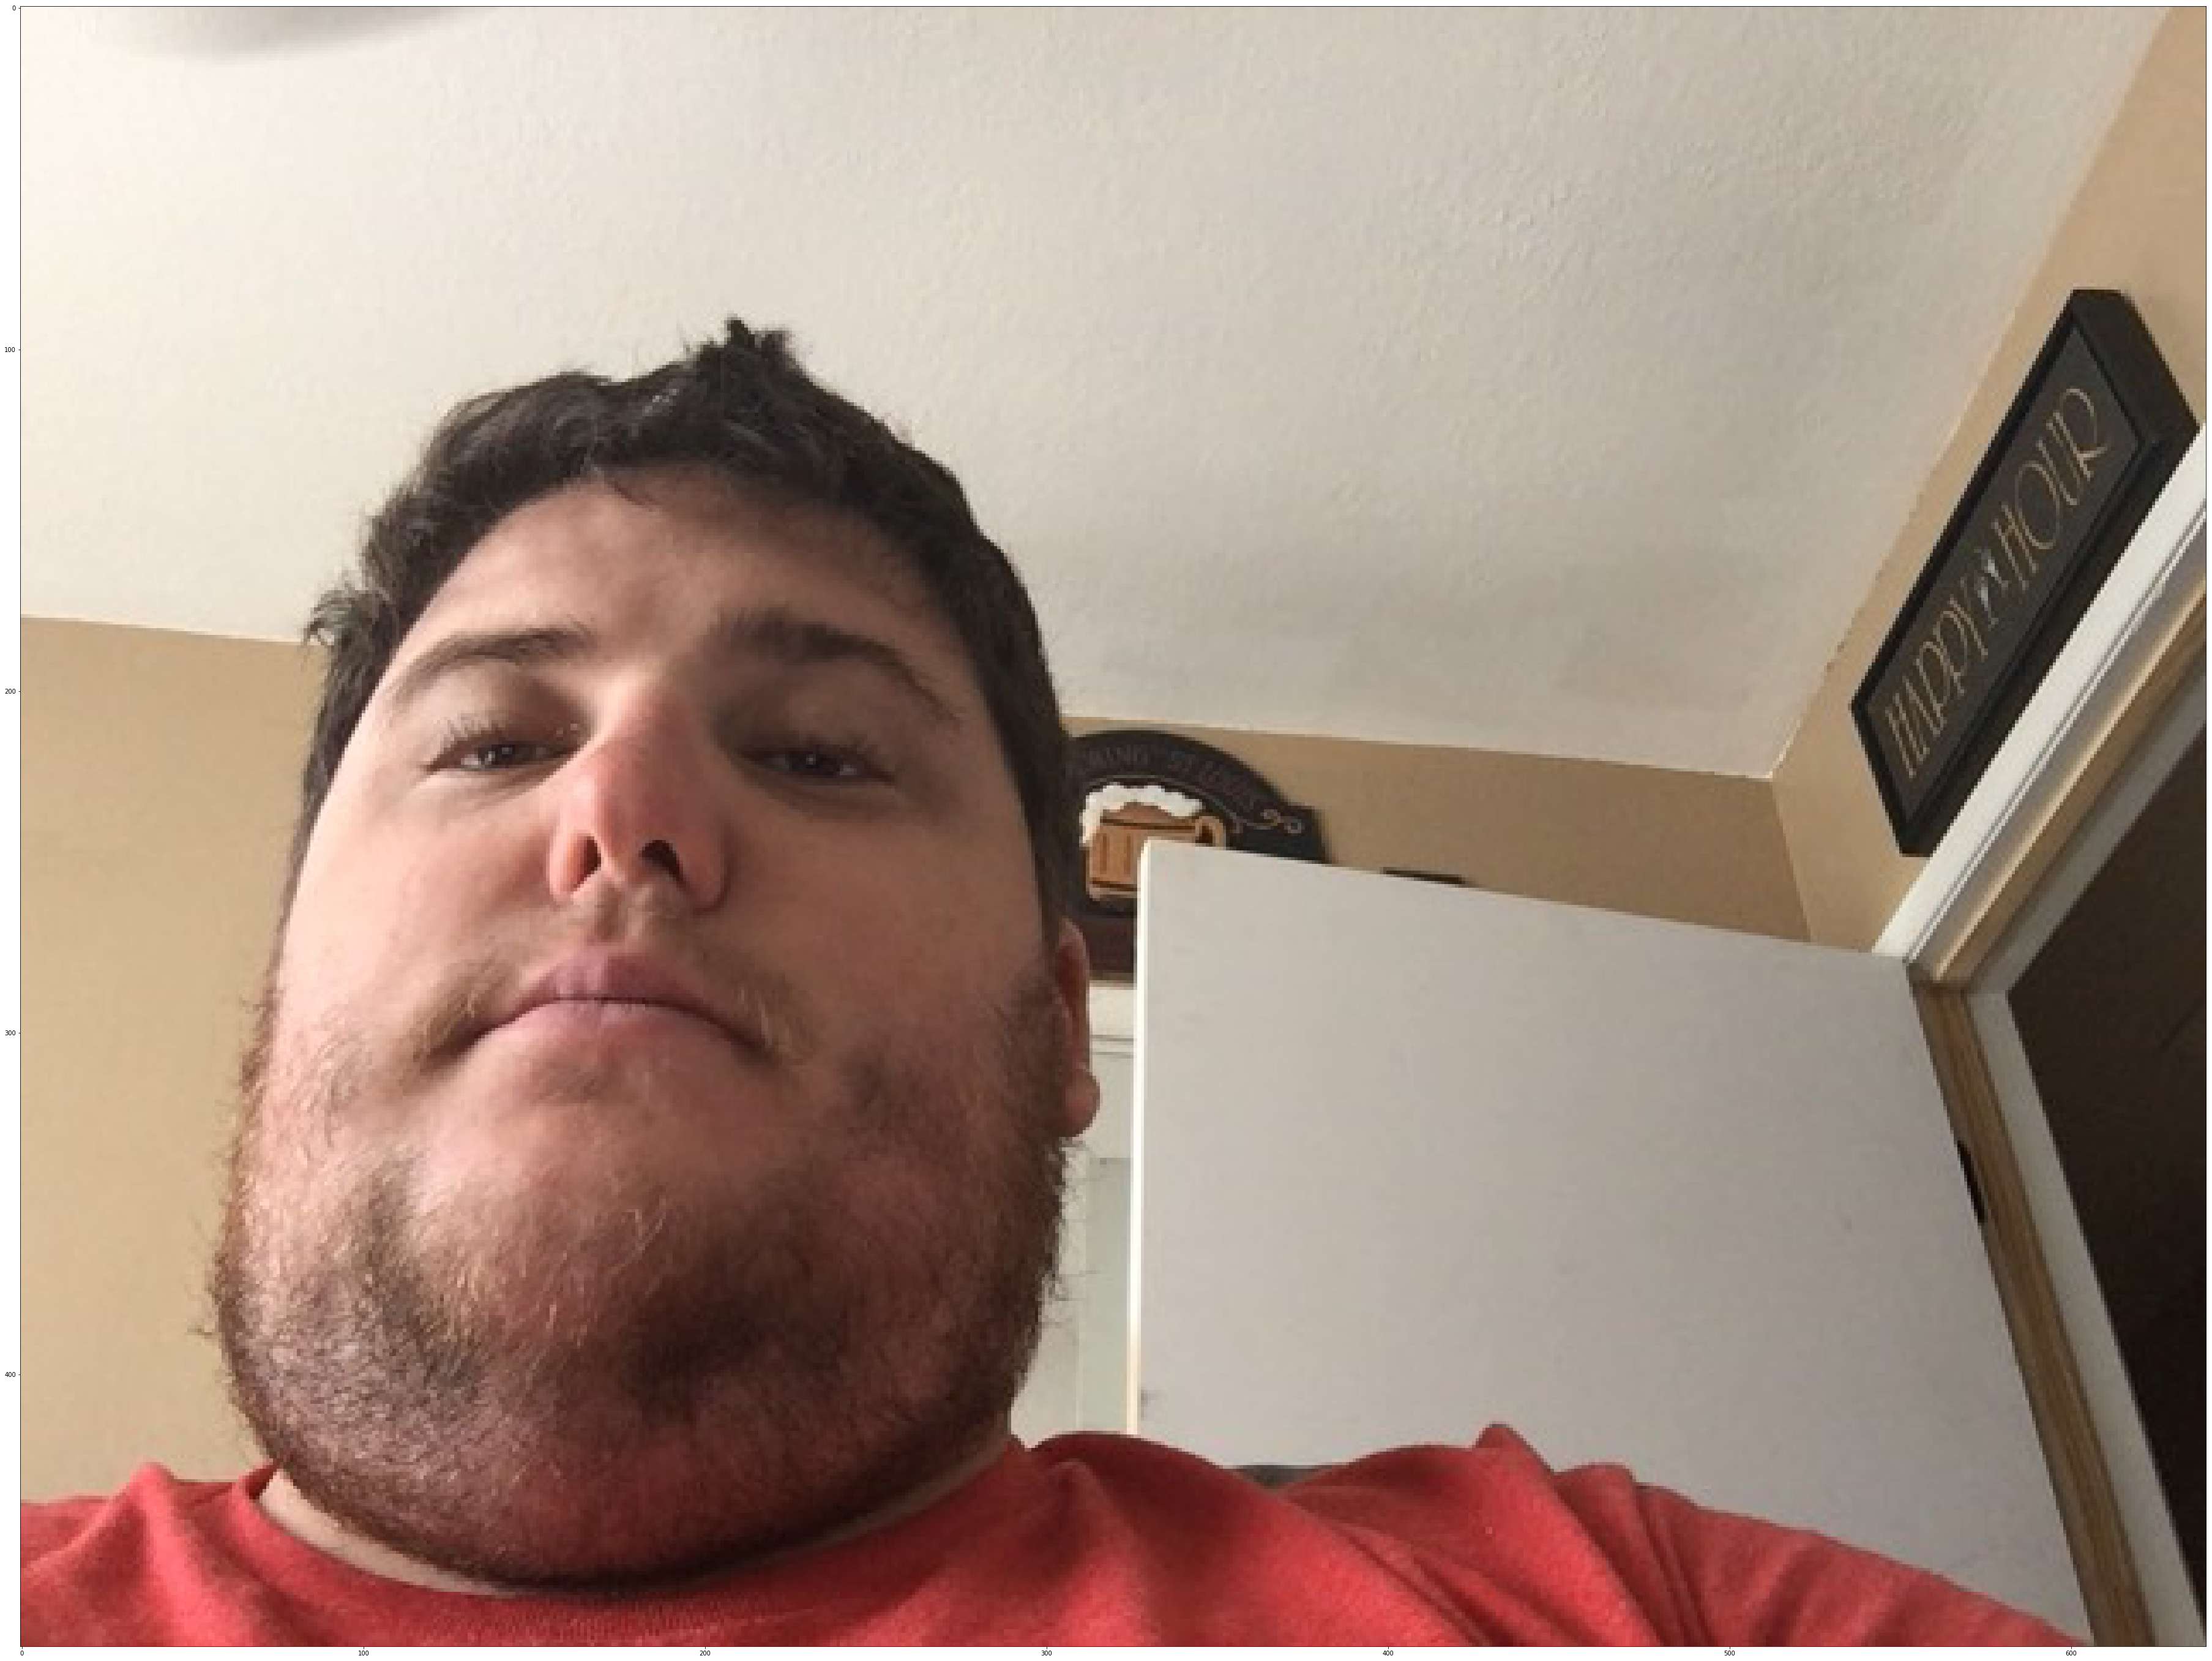

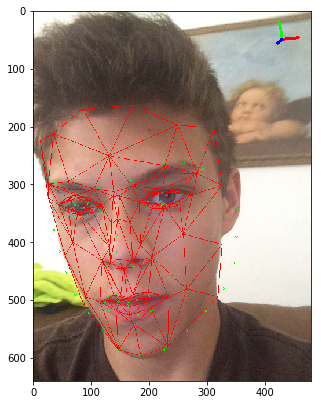

In [28]:
for i, img in enumerate(imgs):
    show_sample(img, i+1)